In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import os
import numpy as np
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
import math
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests as gct
from scipy.stats import pearsonr as pcr
from scipy.stats import spearmanr as spr


#### Function to compute either Pearson's and Spearman's rank correlation on a rolling window basis

In [47]:
def get_roll_corr(df,col1,col2,win=12,corr_type='pcr'):
    '''Function to compute correlation between two signals on a rolling window basis.
        df : dataframe consisting of the two signals
        col1: signal 1
        col2: signal 2
        win: rolling window length, default 12
        corr_type: Pearson or Spearmans Rank correlation.'''
#     df=df.set_index('date')
    num_shifts = len(df[col1].values)-win+1
    pdf=pd.DataFrame(index=np.arange(0,num_shifts),columns=['date','lag','corr','pval'])

    for j in range(0,num_shifts):

        endt=df.index.max()-pd.Timedelta(weeks=j)
        stdt=endt-pd.Timedelta(weeks=win-1)
        if stdt<df.index.min():
            break
        
        res=(0,np.nan)
        
        temp1=df.loc[stdt:endt,col1]
        temp2=df.loc[stdt:endt,col2]
        ind=temp2[temp2.notna()].index
        x1=temp1.loc[ind].values
        x2=temp2.loc[ind].values
        if corr_type=='pcr':
            px=pcr(x1,x2)
            col='pcorr'
        elif corr_type=='spr':
            px=spr(x1,x2)
            col='spr'
#         print(endt,i,pcr(x1,x2))
        if px[0]>res[0] and px[1]<=0.05:
            res=(px[0],px[1])
#             else:
#                 res=(i,np.nan,px[1])
#         print(endt,res)
        pdf.loc[j,'date']=endt
        pdf.loc[j,'corr']=res[0]
        pdf.loc[j,'pval']=res[1]
        pdf.loc[j,'corr_type']=corr_type
        pdf.loc[j,'signals']='{} and {}'.format(col1,col2)
    return pdf

In [48]:
shdf=pd.read_csv('./input/state_hosp.csv').rename(columns={'Unnamed: 0':'date','51':'hosp'})
scdf=pd.read_csv('./input/state_cases.csv').rename(columns={'report_date':'date','VA':'cases'})
scldf=pd.read_csv('./input/state_cli.csv').rename(columns={'st_date':'date','count_of_cli_visits':'CLI'})
sww=pd.read_csv('./input/state_viral_load.csv').rename(columns={'st_date':'date'})

In [49]:
alldf=sww.merge(scdf).merge(shdf).merge(scldf)
alldf=alldf.set_index('date')
alldf.index=pd.to_datetime(alldf.index)

#### Pearson's rank correlation example

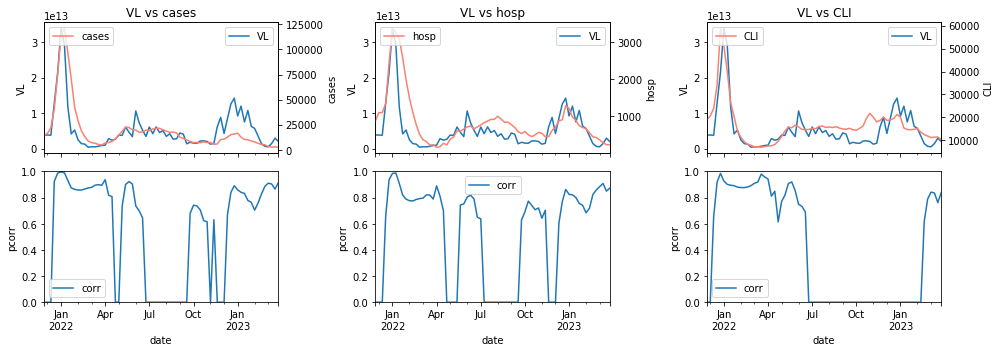

In [51]:
fig,axr=plt.subplots(2,3,figsize=(14,5),sharex=True)
i=0
for col in ['cases','hosp','CLI']:
    ax=axr[0][i]
    alldf[['VL']].plot(ax=ax)
    ax2=ax.twinx()
    alldf[[col]].plot(ax=ax2,color='salmon')
    ax2.legend(loc='upper right')
    ax2.legend(loc='upper left')
    ax.set_ylabel('VL')
    ax2.set_ylabel(col)
    ax.set_title('VL vs {}'.format(col))
    i+=1
i=0
for col in ['cases','hosp','CLI']:
    ax=axr[1][i]
    col1='VL'
    col2=col
    data=alldf[['VL',col]]
    corr=get_roll_corr(data,col1,col2) #get correlation
    corr=corr.dropna(subset=['corr'])
    corr.date=pd.to_datetime(corr.date)
    corr.plot(x='date',y='corr',ax=ax)
    ax.set_ylim([0,1])
    ax.set_ylabel('pcorr')
    i+=1
plt.tight_layout()

#### convert counts to quantiles

In [52]:
qalldf=alldf.copy()
for col in ['VL','cases','hosp','CLI']:
    bins=range(5)
    qalldf.loc[:,col]=pd.qcut(alldf[col],q=5,labels=bins)
qalldf=qalldf.astype(int)


#### Spearman's rank correlation example

/home/aa5dw/miniconda3/envs/fct/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


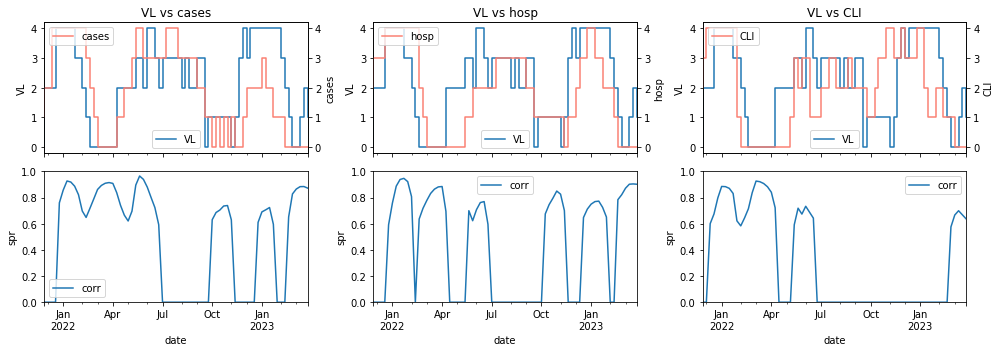

In [53]:
fig,axr=plt.subplots(2,3,figsize=(14,5),sharex=True)
i=0
for col in ['cases','hosp','CLI']:
    ax=axr[0][i]
    qalldf[['VL']].plot(ax=ax,drawstyle="steps-post")
    ax2=ax.twinx()
    qalldf[[col]].plot(ax=ax2,color='salmon',drawstyle="steps-post")
    ax2.legend(loc='upper right')
    ax2.legend(loc='upper left')
    ax.set_ylabel('VL')
    ax2.set_ylabel(col)
    ax.set_title('VL vs {}'.format(col))
    i+=1
i=0
for col in ['cases','hosp','CLI']:
    ax=axr[1][i]
    col1='VL'
    col2=col
    data=qalldf[['VL',col]]
    corr=get_roll_corr(data,col1,col2,corr_type='spr')#get correlation
    corr=corr.dropna(subset=['corr'])
    corr.date=pd.to_datetime(corr.date)
    corr.plot(x='date',y='corr',ax=ax)
    ax.set_ylim([0,1])
    ax.set_ylabel('spr')
    i+=1
plt.tight_layout()

In [116]:
# def get_roll_corr(wwdf,col1,col2,shift=0,corr_type='pcr'):
#     twwdf=wwdf
#     twwdf=twwdf.set_index('date')
#     pdf=pd.DataFrame(index=np.arange(0,100),columns=['date','lag','corr','pval'])
#     win=12

#     for j in range(0,100):

#         endt=twwdf.index.max()-pd.Timedelta(weeks=j)
#         stdt=endt-pd.Timedelta(weeks=win-1)
#         if stdt<twwdf.index.min():
#             break
#         res=(np.nan,0,np.nan)
#         for i in [shift]:
#             temp1=twwdf.loc[stdt:endt,col1]
#             temp2=twwdf.shift(i).loc[stdt:endt,col2]
#             ind=temp2[temp2.notna()].index
#             x1=temp1.loc[ind].values
#             x2=temp2.loc[ind].values
#             if corr_type=='pcr':
#                 px=pcr(x1,x2)
#                 col='pcorr'
#             elif corr_type=='spr':
#                 px=spr(x1,x2)
#                 col='spr'
#     #         print(endt,i,pcr(x1,x2))
#             if px[0]>res[1] and px[1]<=0.05:
#                 res=(i,px[0],px[1])
# #             else:
# #                 res=(i,np.nan,px[1])
# #         print(endt,res)
#         pdf.loc[j,'date']=endt
#         pdf.loc[j,'lag']=res[0]
#         pdf.loc[j,'corr']=res[1]
#         pdf.loc[j,'pval']=res[2]
#     return pdf

In [4]:
# def get_roll_corr(df,col1,col2,shift=0,corr_type='pcr'):
#     '''Function to compute correlation between two signals on a rolling window basis.
#         df : dataframe consisting of the two signals
#         col1: signal 1
#         col2: signal 2
#         corr_type: Pearson or Spearmans Rank correlation.'''
#     twwdf=wwdf
#     twwdf=twwdf.set_index('date')
#     pdf=pd.DataFrame(index=np.arange(0,100),columns=['date','lag','corr','pval'])
#     win=12

#     for j in range(0,100):

#         endt=twwdf.index.max()-pd.Timedelta(weeks=j)
#         stdt=endt-pd.Timedelta(weeks=win-1)
#         if stdt<twwdf.index.min():
#             break
#         res=(np.nan,0,np.nan)
#         for i in [shift]:
#             temp1=twwdf.loc[stdt:endt,col1]
#             temp2=twwdf.shift(i).loc[stdt:endt,col2]
#             ind=temp2[temp2.notna()].index
#             x1=temp1.loc[ind].values
#             x2=temp2.loc[ind].values
#             if corr_type=='pcr':
#                 px=pcr(x1,x2)
#                 col='pcorr'
#             elif corr_type=='spr':
#                 px=spr(x1,x2)
#                 col='spr'
#     #         print(endt,i,pcr(x1,x2))
#             if px[0]>res[1] and px[1]<=0.05:
#                 res=(i,px[0],px[1])
# #             else:
# #                 res=(i,np.nan,px[1])
# #         print(endt,res)
#         pdf.loc[j,'date']=endt
#         pdf.loc[j,'lag']=res[0]
#         pdf.loc[j,'corr']=res[1]
#         pdf.loc[j,'pval']=res[2]
#     return pdf